In [242]:
import requests
import os
import re
import json
import dataclasses as dc
import numpy as np
from dataclasses import field, asdict
from pprint import pprint
from shapely import wkt
from shapely.geometry import Polygon
from datetime import datetime, date, timezone
from pathlib import Path
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt



## GLOBALS

In [246]:
CMR_URL = 'https://cmr.earthdata.nasa.gov/search/granules.json'



## Product Class

In [247]:
@dc.dataclass()
class Product:
    name: str
    shape: Polygon = None
    start: datetime = None
    end: datetime = None
        
    def __post_init__(self):
        self.product_time_regex = re.compile(
                r"S.*1SDV_(?P<start_year>\d{4})(?P<start_month>\d{2})(?P<start_day>\d{2})T(?P<start_hour>\d{2})("
                r"?P<start_minute>\d{2})(?P<start_second>\d{2})_(?P<end_year>\d{4})(?P<end_month>\d{2})(?P<end_day>\d{2})T("
                r"?P<end_hour>\d{2})(?P<end_minute>\d{2})(?P<end_second>\d{2})_*")
#         self.start = make_start(name)
#         self.end = make_end(name)
        self.start = self.make_start(self.name)
        self.end = self.make_end(self.name)
        
        

        
    def make_start(self,product_name) -> datetime:
        
        regex_match = re.match(self.product_time_regex, product_name)
        time_dict = regex_match.groupdict()
        for k, v in time_dict.items():
            time_dict[k] = int(v)

        return datetime(time_dict["start_year"], time_dict["start_month"], time_dict["start_day"],
                        time_dict["start_hour"], time_dict["start_minute"], time_dict["start_second"])



    def make_end(self, product_name) -> datetime:

        regex_match = re.match(self.product_time_regex, product_name)
        time_dict = regex_match.groupdict()
        for k, v in time_dict.items():
            time_dict[k] = int(v)

        return datetime(time_dict["end_year"], time_dict["end_month"], time_dict["end_day"],
                        time_dict["end_hour"], time_dict["end_minute"], time_dict["end_second"])
    
    
    def to_json(self):
        metadata = asdict(self)
        metadata['start'] = self.start.isoformat()
        metadata['end'] = self.end.isoformat()
        metadata['shape'] = str(self.shape)
        
#         for key in list(metadata):
#             if key is datetime:
#                 metadata[key] = metadata[key].isoformat()
#                 print(f"TEST: {key}= {metadata[key]}")
        return json.dumps(metadata)
        
        
    

### Polygon_to_point_str

In [248]:

def polygon_to_point_str(poly: Polygon) -> str:
    """Input Polygon. Returns a CMR compatible point string """
    coord_lst = [coord for coord in list(poly.exterior.coords)]
    pt_lst = []
    for coord in coord_lst:
        for pt in coord:
            pt_lst.append(pt)
            
    listToStr = ','.join(map(str, pt_lst))
    return listToStr
    

#### TEST: polygon_to_point_str

In [249]:
# Test polygon_to_point_str
test_ptps_wkt = "POLYGON((-148.2421 63.9554,-146.4533 63.9554,-146.4533 64.9447,-148.2421 64.9447,-148.2421 63.9554))"
test_ptps_poly= wkt.loads(test_wkt)
test_ptps_point_str = "-148.2421,63.9554,-146.4533,63.9554,-146.4533,64.9447,-148.2421,64.9447,-148.2421,63.9554"


assert polygon_to_point_str(test_ptps_poly)==expected_point_str
print(polygon_to_point_str(test_ptps_poly))

-148.2421,63.9554,-146.4533,63.9554,-146.4533,64.9447,-148.2421,64.9447,-148.2421,63.9554


### product_time

In [250]:
def product_time(product_name):
    product_time_regex = re.compile(
        r"S.*1SDV_(?P<start_year>\d{4})(?P<start_month>\d{2})(?P<start_day>\d{2})T(?P<start_hour>\d{2})("
        r"?P<start_minute>\d{2})(?P<start_second>\d{2})_(?P<end_year>\d{4})(?P<end_month>\d{2})(?P<end_day>\d{2})T("
        r"?P<end_hour>\d{2})(?P<end_minute>\d{2})(?P<end_second>\d{2})_*")

    regex_match = re.match(product_time_regex, product_name)
    time_dict = regex_match.groupdict()

    # converts all dates/times values in dictionary from int to string
    for k, v in time_dict.items():
        time_dict[k] = int(v)

    start = datetime(time_dict["start_year"], time_dict["start_month"], time_dict["start_day"],
                     time_dict["start_hour"], time_dict["start_minute"], time_dict["start_second"])

    end = datetime(time_dict["end_year"], time_dict["end_month"], time_dict["end_day"],
                   time_dict["end_hour"], time_dict["end_minute"], time_dict["end_second"])


    return start, end

### product_in_time_bounds

In [251]:
def product_in_time_bounds(product_name, start, end):
    prod_start, prod_end = product_time(product_name)
    
    return prod_start > start and prod_end < end
    

In [252]:
def format_time(time: datetime):
#     utc_time = time.astimezone(timezone.utc)
#     return utc_time.isoformat(timespec='seconds')
    return time.isoformat()

In [253]:
test_date = datetime(2020,8,1,0,0,0)
print(format_time(test_date))

2020-08-01T00:00:00


### get_cmr_metadata

In [254]:
def get_cmr_metadata(shape:Polygon, start: datetime, end: datetime):
    
    payload = {}
    payload['provider'] = 'ASF'
    payload['temporal'] = (start.isoformat(), end.isoformat())
    payload['polygon'] = polygon_to_point_str(shape)
    payload['short_name'] = (
            'SENTINEL-1A_DP_GRD_HIGH',
            'SENTINEL-1B_DP_GRD_HIGH',
            )
    payload['page_size'] = 100


    response = requests.post(CMR_URL, data=payload)
#     print(response.json)
    products = [
            entry['producer_granule_id'] for entry in response.json()['feed']['entry'] if product_in_time_bounds(entry['producer_granule_id'], start, end)
    ]
    return products
    granules = [
        {
            'name': entry['producer_granule_id'],
#             'polygon': Polygon(format_points(entry['polygons'][0][0]))
        } for entry in response.json()['feed']['entry']
    ]
    response.raise_for_status()
    return granules

## TEST: get_cmr_metadata

In [255]:
test_wkt   = "POLYGON((-148.1418 64.6321,-147.4753 64.6321,-147.4753 64.9466,-148.1418 64.9466,-148.1418 64.6321))"
test_poly  = wkt.loads(test_wkt)
test_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_end   = datetime(year=2020,month=8,day=8,hour=0,minute=0,second=0)

test_products = get_cmr_metadata(test_poly, test_start, test_end)

pprint(test_products)




['S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF',
 'S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8']


### EnhancedJSONEncoder

In [256]:
class EnhancedJSONEncoder(json.JSONEncoder):
    def default(self, o):
        if dc.is_dataclass(o):
            return dc.asdict(o)
        return super().default(o)

## get_products_cmr

In [257]:

# TODO: Get initial queary to return products of proper datetime
def get_products_cmr(shape:Polygon, start: datetime, end: datetime):
    
    payload = {}
    payload['provider'] = 'ASF'
    payload['temporal'] = (start.isoformat(), end.isoformat())
    payload['polygon'] = polygon_to_point_str(shape)
    payload['short_name'] = (
            'SENTINEL-1A_DP_GRD_HIGH',
            'SENTINEL-1B_DP_GRD_HIGH',
            )
    payload['page_size'] = 100

    response = requests.post(CMR_URL, data=payload)
#     pprint(response.json())

    products = []
    for entry in response.json()['feed']['entry']:
        if product_in_time_bounds(entry['producer_granule_id'], start, end):
            products.append(Product(
                                    name = entry['producer_granule_id'],
                                    shape = Polygon(format_points(entry['polygons'][0][0]))
                                   ))

    return products


### TEST: get_products_cmr

In [258]:
test_gpc_wkt   = "POLYGON((-148.1418 64.6321,-147.4753 64.6321,-147.4753 64.9466,-148.1418 64.9466,-148.1418 64.6321))"
test_gpc_poly  = wkt.loads(test_wkt)
test_gpc_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_gpc_end   = datetime(year=2020,month=8,day=15,hour=0,minute=0,second=0)

test_gpc_products = get_products_cmr(test_gpc_poly, test_gpc_start, test_gpc_end)


for product in test_gpc_products:
    print(product.to_json())
    



{"name": "S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF", "shape": "POLYGON ((-147.250381 64.64534, -146.353043 66.116508, -151.962357 66.58766199999999, -152.556412 65.101822, -147.250381 64.64534))", "start": "2020-08-07T16:28:18", "end": "2020-08-07T16:28:43"}
{"name": "S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8", "shape": "POLYGON ((-148.107025 63.174152, -147.250427 64.645256, -152.554779 65.101624, -153.141724 63.616859, -148.107025 63.174152))", "start": "2020-08-07T16:28:43", "end": "2020-08-07T16:29:08"}
{"name": "S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21", "shape": "POLYGON ((-143.374802 64.30976099999999, -142.475571 65.779594, -147.98317 66.24443100000001, -148.589005 64.759766, -143.374802 64.30976099999999))", "start": "2020-08-09T16:11:56", "end": "2020-08-09T16:12:21"}
{"name": "S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635", "shape": "POLYGON ((-144.179428 62.834026, -143.374

In [259]:


def create_directories(root_path: Path) -> None:
    """Creates the directories for storing our data"""
    
    PROJECT_ROOT = root_path.resolve().parents[1]
    
    # Path configurations for data directory
    DATA_DIR = PROJECT_ROOT / "data"

    GRANULES_DIR    = DATA_DIR / "granules"
    TILES_DIR       = DATA_DIR / "tiles"
    SHAPEFILE_DIR   = DATA_DIR / "shape_files"
    WATER_MASKS_DIR = DATA_DIR / "water_masks"
    
    
    directories = [GRANULES_DIR, SHAPEFILE_DIR, TILES_DIR, WATER_MASKS_DIR]
    for directory in directories:
        directory.mkdir(parents=True)

In [260]:
# with TemporaryDirectory() as tmpdir_name:
#     tmpdir_path = Path(tmpdir_name)
#     create_directories(tmpdir_path)
#     print(os.listdir(f"{str(tmpdir_path)}"))
    
    
with TemporaryDirectory() as tmpdir_name:
    
    tmpdir_path = Path(tmpdir_name)
    
    TILES_DIR       = tmpdir_path / "tiles/"
    GRANULES_DIR    = tmpdir_path / "granules"
    SHAPEFILE_DIR   = tmpdir_path / "shape_files"
    WATER_MASKS_DIR = tmpdir_path / "water_masks"
    
    directories = [GRANULES_DIR, SHAPEFILE_DIR, TILES_DIR, WATER_MASKS_DIR]
    for directory in directories:
        directory.mkdir(parents=True)
        
    print(f"Temp dirs created: {os.listdir(str(tmpdir_path))}")
    
    
    

Temp dirs created: ['shape_files', 'granules', 'tiles', 'water_masks']


In [299]:
def triage_products(products):
    return sorted(products, key=lambda product: product.start)

In [ ]:
def get_min_granule_coverage(products, aoi):
    products = triage_products(products)
    polys = [product.shape for product in products]
    
    for product in products:
        if product.shape
        
    

## RUN

S1B_IW_GRDH_1SDV_20200801T030347_20200801T030412_022724_02B20B_927C
S1B_IW_GRDH_1SDV_20200801T030412_20200801T030437_022724_02B20B_0CBB
S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF
S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8
S1B_IW_GRDH_1SDV_20200809T033631_20200809T033656_022841_02B5B0_6CD7
S1B_IW_GRDH_1SDV_20200809T033656_20200809T033721_022841_02B5B0_147A
S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21
S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635
S1B_IW_GRDH_1SDV_20200811T032006_20200811T032031_022870_02B695_B919
S1B_IW_GRDH_1SDV_20200811T032031_20200811T032056_022870_02B695_52D8
S1B_IW_GRDH_1SDV_20200811T032056_20200811T032121_022870_02B695_27E2
S1B_IW_GRDH_1SDV_20200813T030348_20200813T030413_022899_02B76C_7220
S1B_IW_GRDH_1SDV_20200813T030413_20200813T030438_022899_02B76C_C6FA
S1B_IW_GRDH_1SDV_20200801T030347_20200801T030412_022724_02B20B_927C
S1B_IW_GRDH_1SDV_20200801T030412_20200801T030437

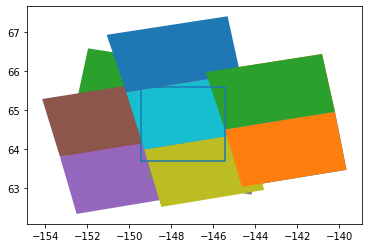

In [300]:
%matplotlib inline








test_aoi_wkt = "POLYGON((-149.4512 63.6973,-145.4227 63.6973,-145.4227 65.6,-149.4512 65.6,-149.4512 63.6973))"
test_aoi_poly  = wkt.loads(test_aoi_wkt)
test_aoi_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_aoi_end   = datetime(year=2020,month=8,day=15,hour=0,minute=0,second=0)

test_aoi_products = get_products_cmr(test_aoi_poly, test_aoi_start, test_aoi_end)


for product in test_aoi_products:
    print(product.name)
    
sorted_products = triage_products(test_aoi_products)
    
for product in sorted_products:
    print(product.name)

x,y = test_aoi_poly.exterior.xy
plt.plot(x,y)

for product in sorted_products:
    x,y = product.shape.exterior.xy
    plt.fill(x,y)

    
    
    
    
    
    
    
    
    
    
    

# with TemporaryDirectory() as tmpdir_aiwater:
    

    